# III. Filter data using Cordoni's algorithm

> Francisco Carrasco Varela - Pontificia Universidad Católica de Chile (PUC) - ffcarrasco@uc.cl ⭐

<center>
<mark>The following Jupyter Notebook is used to extract and work with Gaia DR3 data<br>
    (and other data releases) </mark>
</center>

In [1]:
# Import all the libraries we will need

%matplotlib inline
from dataclasses import dataclass, field
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib
import numpy as np
import os
from astropy.io import ascii
from astropy.table import vstack, Table
from tabulate import tabulate
from numpy import ones
from numpy import vstack as npvstack
from numpy.linalg import lstsq

import sys
sys.path.insert(0, '../Scripts/')
import Parameters as PR

# 1 -. Creating Bins and extracting parameters

The following step on this Notebook will follow the procedure given by [Cordoni et. al (2018)](https://ui.adsabs.harvard.edu/abs/2018ApJ...869..139C/abstract) and [Cordoni et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020ApJ...889...18C/abstract). Even if it has been applied for Gaia DR2, this method avoid fake members using multiple filters and there is no current reason why this method could not be applied to Gaia DR3 as well.

## 1.1 -. Reading Previous Data

First of all, read the data from previous steps. If you do not have done previous steps, please follow the previous instructions before proceeding with this step; since some files generated by previous steps are needed.

In [2]:
# Get data from Vasiliev (2019) file

###################################################
object_name = "NGC104"  # <--- OBJECT NAME FROM PREVIOUS STEPS, EDITABLE
vasiliev_file = "../ObservedData/Vasiliev_2019_Gaia_parameters.dat"
###################################################


data_list = PR.get_GC_params(vasiliev_file)
obj, success = PR.get_selected_GC(object_name, data_list)

if success:
    n_times = 60 # Number of times we will print '-' character
    print("Object detected succesfully!")
    print("-"*n_times)
    print(f"Object name: {obj.name}")
    print(f"Mean Proper Motion RA (mas/yr): {obj.pm_RA} +- {obj.err_pm_RA}")
    print(f"Mean Proper Motion DEC (mas/yr): {obj.pm_DEC} +- {obj.err_pm_DEC}")
    print("-"*n_times)
    
def check_if_file_exists(filename_path: str) -> None:
    """
    Checks if a file with filtered data that should have been created in the previous step
    of this Notebook is created. If it is not created it will exit the program.
    You should run the previous step of this Notebook then.
    """
    isExist = os.path.exists(filename_path)
    if not isExist:
        print(f"Warning! {filename_path} file not found.")
        print("You must fully run the previous step in this Notebook and create a file with ", end='')
        print("filtered data before running this cell.")
        sys.exit("Create filtered file in previous Notebook step and retry.")
    return

dir_path = f"../Objects/{obj.name.upper()}/"
save_filename = f"2_{obj.name.upper()}_f_data.dat"

filename_filtered_path = f"{dir_path}{save_filename}"

# Check if the filtered file created in the previous step of thi Notebook exists
check_if_file_exists(filename_filtered_path)

gaia_data = Table.read(filename_filtered_path, format='ascii.ecsv') # get data from previous Notebook step
print('Data read sucessfully')

Object detected succesfully!
------------------------------------------------------------
Object name: NGC104
Mean Proper Motion RA (mas/yr): 5.237 +- 0.039
Mean Proper Motion DEC (mas/yr): -2.524 +- 0.039
------------------------------------------------------------
Data read sucessfully


## 1.2 -. Create Bins
First of all, [Cordoni et. al (2018)](https://ui.adsabs.harvard.edu/abs/2018ApJ...869..139C/abstract) (hereafter [C18](https://ui.adsabs.harvard.edu/abs/2018ApJ...869..139C/abstract)) say that they use $G_\text{RP}$ parameter to divide the data into sub-sections. This procedure is also used in [Cordoni et al. 2020](https://ui.adsabs.harvard.edu/abs/2020ApJ...889...18C/abstract) (hereafter [C20](https://ui.adsabs.harvard.edu/abs/2020ApJ...889...18C/abstract)). In the last study mentioned, they use values between $11.0$ and $18.5$ for $G_\text{RP}$, where every sub-section has a "size" of $0.5$ magnitudes. For this Notebook purposes, **every sub-section will be called a bin**. Hence, [C20](https://ui.adsabs.harvard.edu/abs/2020ApJ...889...18C/abstract) uses a total of 15 bins. 

However, to do this more "customizable" for the user who wants to use this notebook, I decided to make 2 littles changes:
- You can select the minimum and maximum magnitudes in $G_\text{RP}$
- You can select the number of bins that will be created between these two limits.

So, for instance, if you want to exactly replicate what has been done by [C20](https://ui.adsabs.harvard.edu/abs/2020ApJ...889...18C/abstract), you can set the min. for $G_\text{RP}$ as $11.0$, the max. as $18.5$ and set the number of bins to 15 (see the cell below, or search for `EDITABLE` comment).

Nevertheless, it is first recommendable to "let the data speak". So before setting custom upper/lower limits, you must check the range of magnitudes your data is. Based on my experience, if magnitudes are fainter than $19.5$ data starts to be less reliable; since its errors start to grown. For that reason, if a data is fainter than $19.5$ in $G_\text{RP}$, we "cut it" into $19.5$. You can modify this "lower limit cut", but I do not recommend it. A lower limit (for stars/objects that are too bright) set is usually around $ G_\text{RP} \sim 11$ mags, as has been pointed out by [C18](https://ui.adsabs.harvard.edu/abs/2018ApJ...869..139C/abstract) and [C20](https://ui.adsabs.harvard.edu/abs/2020ApJ...889...18C/abstract). So, in summary, if a value is outside the range [11, 19] it will be automatically "cut". If you do not like this you can manually modify `checkMinAndMaxValues` function in cell below; however, and again, I do not recommend it.

For this method, we are interested in the following 4 parameters **for every bin**:
- $G_\text{RP}$: Gaia RP magnitude mean and its standard deviation (in mags)
- $\mu_\text{R}$: Mean proper montion for the bin,

where $\mu_\text{R}$ is defined as:

  $$
  \mu_\text{R} = \sqrt{(\mu_\alpha \cos \alpha - \langle \mu_\alpha \cos \alpha \rangle)^2 + (\mu_\delta - \langle \mu_\delta \rangle)^2}
  $$
  
  where $\mu_\alpha \cos \alpha$ is the proper motion in the $\alpha$ (Right Ascension) component and $\mu_\delta$ in the $\delta$ (Declination) component. $\langle \mu_\alpha \cos \alpha \rangle$ (and same goes for $\mu_\delta$) is the mean proper motion obtained obtained by Vasiliev. If the object is in not in Vasiliev object list, then its value is obtained getting the median for the respective parameter (RA or DEC). A higher number of iterations in the algorithm is recommended for a more accurate filtering, where a new median proper motion is computed for every iteration.
- $\texttt{as_gof_al}$: "indicative of the goodness-of-fit statistics of the astrometric solution for the source in the along-scan direction". Its median value and its standard deviation
- $\pi$: Parallax measured by Gaia. Its median value and its standard deviation (mili-arcseconds)

For every parameter we will also obtain its standard deviation. In such a way that, for every bin, we define points in the space $[\text{Value}, G_{RP}]$ with coordinates

$$[\text{Median Value}+\sigma \times \text{std(Value)}, \text{Mean} \ G_{RP}]$$

where $\text{Value}$ is $\mu_R$ or $\text{as_gof_al}$ parameters. $\sigma = 4$ in [C18](https://ui.adsabs.harvard.edu/abs/2018ApJ...869..139C/abstract) and [C20](https://ui.adsabs.harvard.edu/abs/2020ApJ...889...18C/abstract).

Only for $\pi$ (parallax), we compute two points given by:

$$[\langle \pi \rangle \pm \sigma \times \text{std}(\pi), \langle G_RP \rangle]$$

Finally, with those points we have just obtained, we interpolate them and see if data lies in values smaller or greater than the interpolated line. If they are out of range, data is discarded. Otherwise it is selected.

In [123]:
####################################################################################################
####################################################################################################
nDiv: int = 20 # EDITABLE <---- Number of bins
nIter: int = 1 # EDITABLE <---- Number of iterations for the algorithm
Sigma: float = 4 # EDITABLE <--- Standard deviation tolerance for data
setLimits: bool = False # <---- Do you want to set your own upper/lower limits for G_RP magnitude?
G_RP_upper_limit: float = 19.5 # If above is True, put your custom upper limit value here (in mags)
G_RP_lower_limit: float = 11.0 # Your custom lower limit value here (in mags)
wantToPrintBins = True # Do you want to print in screen bins that will be created?
####################################################################################################
####################################################################################################

@dataclass(kw_only=True)
class euclidianPoint():
    x: float
    y: float
    

@dataclass(kw_only=True)
class singlePoint():
    ID: int
    median_value: float
    std_value: float
    G_RP_mean: float
    G_RP_std : float
    m: float = 0.
    c: float = 0.
    
    
@dataclass(kw_only=True)
class pointsToInterpolate():
    points: list[singlePoint] = field(default_factory=list)


@dataclass
class parameterList:
    G_BP: list[float] = field(default_factory=list)
    G_RP: list[float] = field(default_factory=list)
    as_gof_al: list[float] = field(default_factory=list)
    parallax: list[float] = field(default_factory=list)
    mu_R: list[float] = field(default_factory=list)
        
    
@dataclass(kw_only=True)
class Bin:
    ID: int = 0
    params: parameterList = field(default_factory=list)
    minVal_G_RP: float 
    maxVal_G_RP: float
        
    def __post_init__(self):
        self.mean_G_RP = np.mean(self.params.G_RP)
        self.mean_G_BP = np.mean(self.params.G_BP)
        self.median_as_gof_al = np.median(self.params.as_gof_al)
        self.median_parallax = np.median(self.params.parallax)
        self.median_mu_R = np.median(self.params.mu_R)
        self.std_dev_G_RP = np.std(self.params.G_RP, ddof=1)
        self.std_dev_G_BP = np.std(self.params.G_BP, ddof=1)
        self.std_dev_as_gof_al = np.std(self.params.as_gof_al, ddof=1)
        self.std_dev_parallax = np.std(self.params.parallax, ddof=1)
        self.std_dev_mu_R = np.std(self.params.mu_R, ddof=1)
        

@dataclass(kw_only=True)
class TotalBins:
    bins: list[Bin] = field(default_factory=list)
        

def getImportantParameters(originalData: Table) -> parameterList:
    """
    Extract only important parameters that will be used later for
    Cordoni et al. (2020) algorithm
    """
    importantParameters = parameterList()
    if success: # object is in Vasiliev's list
        median_PM_RA = obj.pm_RA
        median_PM_DEC = obj.pm_DEC
    if not success: # object is not in Vasiliev's list, get them 'manually'
        median_PM_RA = np.median(originalData['pmra']) 
        median_PM_DEC = np.median(originalData['pmdec'])
    for x in range(0, len(originalData)):
        importantParameters.G_RP.append(originalData[x]["phot_rp_mean_mag"])
        importantParameters.G_BP.append(originalData[x]["phot_bp_mean_mag"])
        importantParameters.as_gof_al.append(originalData[x]["astrometric_gof_al"])
        importantParameters.parallax.append(originalData[x]["parallax"])
        importantParameters.mu_R.append(
                                 estimateMUsubR(PM_alpha=originalData[x]['pmra'],
                                   PM_delta=originalData[x]['pmdec'],
                                   previous_PM_alpha_median=median_PM_RA,
                                   previous_PM_delta_median=median_PM_DEC))   
    # Check if lists have the same size
    list_of_lists = [importantParameters.G_BP, importantParameters.G_RP,
                     importantParameters.as_gof_al, importantParameters.parallax,
                     importantParameters.mu_R, originalData]
    if all(len(list_of_lists[0]) == len(l) for l in list_of_lists[1:]):
        sameListSize = True
    else:
        sameListSize = False
    assert sameListSize, "Lists do not have the same size!"
        
    return importantParameters

def whichParameter(parameters_in_list: parameterList,
                   paramName: str):
    if paramName == "astrometric_gof_al" or paramName == "as_gof_al":
        return parameters_in_list.as_gof_al
    if paramName == "phot_rp_mean_mag" or paramName == "G_RP":
        return parameters_in_list.G_RP
    if paramName == "phot_bp_mean_mag" or paramName == "G_RP":
        return parameters_in_list.G_BP
    if paramName == "parallax":
        return parameters_in_list.parallax
    if paramName == "mu_R" or paramName == "muR":
        return parameters_in_list.mu_R
    sys.exit("No valid parameter was returned")
        
def estimateMUsubR(PM_alpha: float,
                   PM_delta: float,
                   previous_PM_alpha_median: float = 0.,
                   previous_PM_delta_median: float = 0.
                   ) -> float:
    """
    Estimates mu_R as defined by Cordoni et al. (2018)
    """
    return np.sqrt( np.power(PM_alpha - previous_PM_alpha_median, 2) + 
                   np.power (PM_delta - previous_PM_delta_median, 2) )


def checkMinAndMaxValues(minValue: float, maxValue: float, useCustomLimits: bool,
                        ) -> (float, float):
    """
    As suggested by Cordoni et al. (2020), values for RP Gaia magnitudes
    should have an upper and lower limit. If the min/max value is
    lower/bigger than these values, then simply "cut" min/max values
    in those limits.
    """
    if useCustomLimits: # if the user wants to use custom values for upper and lower limits...
        Cordoni_lower_mag = G_RP_lower_limit
        Cordini_upper_mag = G_RP_upper_limit
        
    if not useCustomLimits: # if not, check if they surpass acceptables values. 
                            # If they do, replace them...
         Cordoni_lower_mag = 10.5
         Cordoni_upper_mag = 19.5
    
    if maxValue > Cordoni_lower_mag:
        maxValue = Cordoni_upper_mag
    if minValue < Cordoni_lower_mag:
        minValue = Cordoni_lower_mag
    
    return minValue, maxValue
                

def getBinSize(values: list[float], 
               numberOfDivisions: int
              ) -> (float, float, float):
    """
    Obtains the maximum and minimum value of a list and returns the difference value
    between each number that results dividing the max - min divided into N parts,
    i.e., bin size. 
    Returns the minimum, maximum and size of each bin after dividing this interval
    into N parts.
    """
    assert (numberOfDivisions != 0), "You cannot divide by zero"
    assert (numberOfDivisions != 1),  "Dividing by 1 division is nonsense"
    
    maxValue: float = np.amax(values)
    minValue: float = np.amin(values)
    
    minValue, maxValue = checkMinAndMaxValues(minValue, 
                                              maxValue, 
                                              setLimits)

    return maxValue, minValue, (maxValue - minValue)/ (1.0*numberOfDivisions)


def printValuesBins(maxValue: float, 
                    minValue: float,
                    nBins: int,
                    binValue: float,
                    totalBins: TotalBins,
                    printMoreDetails: True
                   ) -> None:
    """
    A simple print statement to check values obtained from
    getBinSize function.
    """
    
    if printMoreDetails:
        print("\n\n")
        len_marker: int = 90
        print(len_marker*"=")
        text: str = "Estimated values are: "
        for j in range(1, 5):
            if j == 1:
                print(f"{text}{j}) Max Value G_RP (mag): {maxValue:.3f} # Maximum value for G_RP magnitude")
            
            if j != 1:
                print(len(text)*" " + f"{j}) ", end='')
                
                if j == 2:
                    print(f"Min Value G_RP (mag): {minValue:.3f} # Minimum value for G_RP magnitude")
                
                if j == 3:
                    print(f"Number of req. Bins: {nBins} # Number of requested Bins")
                
                if j == 4:
                    print(f"Bin Range G_RP (mag): {binValue:.3f} # Value of size/range for every bin")
        print(len_marker*"=", end="\n\n")
    
    data_list = []
    
    for data in totalBins.bins:
        temp_list = []
        temp_list.append(data.ID)
        temp_list.append(len(data.params.G_RP))
        temp_list.append(f"{data.mean_G_RP:.3f} ± {data.std_dev_G_RP:.3f}")
        temp_list.append(f"{data.median_as_gof_al:.3f} ± {data.std_dev_as_gof_al:.2f}")
        temp_list.append(f"{data.median_mu_R:.3f} ± {data.std_dev_mu_R:.3f}")
        temp_list.append(f"{data.median_parallax:.3f} ± {data.std_dev_parallax:.3f}")
        data_list.append(temp_list)
    print()
    print(tabulate(data_list, headers=["Bin ID", "N", "<G_RP> (mag)",\
                                      "<as_gof_al>", "<μ_R> (mas/yr)", "<π> (mas)"], \
                                      tablefmt='grid'))
    return


def createBins(astrodata: Table, nDivision: int,
               printingBins: bool = False
               ) -> TotalBins:
    """
    Data will be splitted into nDivision bins. This functions creates
    those bins.
    """
    # Select G_RP column
    G_RP_gaia_data = astrodata['phot_rp_mean_mag']
    # Estimate bin sizes
    maxVal, minVal, binVal = getBinSize(G_RP_gaia_data, nDiv)
    totBins = TotalBins()
    
    # mu_R uses median for pmra and pmdec, so check if the object
    # is in Vasiliev's list (which include these values)
    if success: # object is in Vasiliev's list
        previous_median_PM_RA = obj.pm_RA
        previous_median_PM_DEC = obj.pm_DEC
    if not success: # object is not in Vasiliev's list, get them 'manually'
        previous_median_PM_RA = np.median(astrodata['pmra']) 
        previous_median_PM_DEC = np.median(astrodata['pmdec'])
    
    print("Creating Bins...", end="\n\n")

    # Add data for every bin
    for j in range(0, nDiv):
        minMag_G_RP_bin: float = minVal+(binVal * j)
        maxMag_G_RP_bin: float = minVal + (binVal *(j+1))
        print(f'Bin number -> {j+1}: [{minMag_G_RP_bin:.3f}, {maxMag_G_RP_bin:.3f}]')
        tempParamater = parameterList()
        tempPM_RA, tempPM_DEC = [], []
        for tempData in astrodata:
            # Main condition to define a bin, given by Cordoni et al. (2020)
            # If data is between the maximum and minimim value for the current bin...
            mainCondition = minMag_G_RP_bin <= tempData['phot_rp_mean_mag'] < maxMag_G_RP_bin
            # Second simple condition to avoid masked numpy null values in CMD
            secondCondition = -25 < tempData['phot_bp_mean_mag'] <= 25
            # If the value lies inside the range of values 
            # of the expected bin, then...
            if mainCondition and secondCondition:
                tempParamater.G_BP.append(tempData['phot_bp_mean_mag'])
                tempParamater.G_RP.append(tempData['phot_rp_mean_mag'])
                tempParamater.as_gof_al.append(tempData['astrometric_gof_al'])
                tempParamater.parallax.append(tempData['parallax'])
                tempPM_RA.append(tempData['pmra'])
                tempPM_DEC.append(tempData['pmdec'])
                tempParamater.mu_R.append(
                    estimateMUsubR(PM_alpha=tempData['pmra'],
                                   PM_delta=tempData['pmdec'],
                                   previous_PM_alpha_median=previous_median_PM_RA,
                                   previous_PM_delta_median=previous_median_PM_DEC))                                 
        newBin = Bin(ID=j+1, 
                     params=tempParamater, 
                     minVal_G_RP=minMag_G_RP_bin, 
                     maxVal_G_RP=maxMag_G_RP_bin)
        totBins.bins.append(newBin)
        
    # Optional: print results obtained for the bin
    if printingBins:
        printValuesBins(maxVal, minVal, nDivision, 
                        binVal, totBins, 
                        printMoreDetails=False)
    return totBins

def interpolateData(data: Table,
                    totalBins: TotalBins,
                    varToInterpolate: str,
                    sigma: float) -> np.ndarray:
    """
    Interpolate data given a parameter as specified by
    Cordoni et al. (2018)
    """
    points_as_gof_al = createPointsToInterpolate(
                             totalBins=totalBins,
                             varToInterpolate=varToInterpolate,
                             sigma=sigma
                             )  
    return
    
def CordiniAlgorithm(initialData: Table,
                     nIterations: int,
                     nDivisions: int,
                     printBins: bool
                     ) -> Table:
    """
    Cordoni. et al (2018) alrogithm applied
    """
    # Iterate the number of times requested by user
    for iteration in range(1, nIterations+1):
        print(f'##### ITERATION {iteration} #####\n')
        totBins = createBins(astrodata=initialData, 
                             nDivision=nDivisions,
                             printingBins=printBins)
        
        
    return totBins #it should return none. Returns totBins just to test

usefulParameters = getImportantParameters(originalData=gaia_data)


totalCustomBins = CordiniAlgorithm(initialData=gaia_data,
                 nIterations=nIter,
                 nDivisions=nDiv,
                 printBins=wantToPrintBins)



##### ITERATION 1 #####

Creating Bins...

Bin number -> 1: [10.527, 10.976]
Bin number -> 2: [10.976, 11.424]
Bin number -> 3: [11.424, 11.873]
Bin number -> 4: [11.873, 12.322]
Bin number -> 5: [12.322, 12.770]
Bin number -> 6: [12.770, 13.219]
Bin number -> 7: [13.219, 13.668]
Bin number -> 8: [13.668, 14.116]
Bin number -> 9: [14.116, 14.565]
Bin number -> 10: [14.565, 15.014]
Bin number -> 11: [15.014, 15.462]
Bin number -> 12: [15.462, 15.911]
Bin number -> 13: [15.911, 16.359]
Bin number -> 14: [16.359, 16.808]
Bin number -> 15: [16.808, 17.257]
Bin number -> 16: [17.257, 17.705]
Bin number -> 17: [17.705, 18.154]
Bin number -> 18: [18.154, 18.603]
Bin number -> 19: [18.603, 19.051]
Bin number -> 20: [19.051, 19.500]

+----------+------+----------------+---------------+------------------+---------------+
|   Bin ID |    N | <G_RP> (mag)   | <as_gof_al>   | <μ_R> (mas/yr)   | <π> (mas)     |
+==========+======+================+===============+==================+===============+
|

# 2 -. Interpolate and extrapolate data

In [124]:
def eq_straight_line(P1, P2: euclidianPoint) -> (float, float):
    "Return the equation of a straight line given two points with \
    coordinates P1 = (x1, y1) and P2 = (x2,y2)"
    points = [(P1.x, P1.y),(P2.x, P2.y)]
    x_coords, y_coords = zip(*points)
    A = npvstack([x_coords,ones(len(x_coords))]).T
    m, c = lstsq(A, y_coords)[0]
    # print("Line Solution is y = {m}x + {c}".format(m=m,c=c))
    return m, c


def createPointsToInterpolate(totalBins: TotalBins,
                             varToInterpolate: str,
                             sigma: float = Sigma,
                             ) -> pointsToInterpolate:
    """
    Create points that will be used to create interpolation lines that
    will be used to filter data
    """
    points = pointsToInterpolate()
    paramsToInterpolate=["as_gof_al", "astrometric_gof_al", "mu_R", "parallax"]
    # Create basic points to interpolate
    for index, data in enumerate(totalBins.bins):
        if varToInterpolate == "as_gof_al" or varToInterpolate == "astrometric_gof_al":
            temp_median_var = data.median_as_gof_al
            temp_std_var = data.std_dev_as_gof_al
        if varToInterpolate == "mu_R":
            temp_median_var = data.median_mu_R
            temp_std_var = data.std_dev_mu_R
        if varToInterpolate == "parallax":
            temp_median_var = data.median_parallax
            temp_std_var = data.std_dev_parallax
        if varToInterpolate not in paramsToInterpolate:
            print("Invalid parameter to filter!")
            sys.exit(1)
        tempPoint = singlePoint(
                    ID=index+1,
                    median_value=temp_median_var,
                    std_value=temp_std_var,
                    G_RP_mean=data.mean_G_RP,
                    G_RP_std=data.std_dev_G_RP)
        points.points.append(tempPoint)
    # Check that both list have the same size at this point
    checkLists = len(totalBins.bins) == len(points.points)
    assert checkLists, "Bins list and point list must have the same size!" 
    
    for index in range(0, len(points.points)-1):
        p1 = euclidianPoint(y=points.points[index].median_value \
                              + sigma*points.points[index].std_value, 
                            x=points.points[index].G_RP_mean)
        p2 = euclidianPoint(y=points.points[index+1].median_value \
                              + sigma*points.points[index+1].std_value, 
                            x=points.points[index+1].G_RP_mean)
        inclination, intersection = eq_straight_line(P1=p1, P2=p2)
        points.points[index].m = inclination
        points.points[index].c = intersection
        
    # Append first and last points
    firstPoint = points.points[0]
    points.points.insert(0,singlePoint(ID=0, median_value=firstPoint.median_value,
                         std_value= firstPoint.std_value,
                         G_RP_mean= np.amin(totalBins.bins[0].params.G_RP),
                         G_RP_std = 0.,
                         m= 0.,
                         c= firstPoint.median_value + Sigma * firstPoint.std_value))
    lastPoint = points.points[-1] 
    points.points.append(singlePoint(ID=lastPoint.ID + 1,
                         median_value=lastPoint.median_value,
                         std_value=lastPoint.std_value,
                         G_RP_mean=np.amax(totalBins.bins[-1].params.G_RP),
                         G_RP_std=0.,
                         m=0.,
                         c=lastPoint.median_value + Sigma*lastPoint.std_value))
    
    # Re-compute the value for the semi-last point
    # (we could not do this since we did not have the last point until now)
    p1 = euclidianPoint(y=points.points[-2].median_value \
                              + sigma*points.points[-2].std_value, 
                            x=points.points[-2].G_RP_mean)
    p2 = euclidianPoint(y=points.points[-1].median_value \
                              + sigma*points.points[-1].std_value, 
                            x=points.points[-1].G_RP_mean)
    inclination, intersection = eq_straight_line(P1=p1, P2=p2)
    points.points[-2].m = inclination
    points.points[-2].c = intersection
    points.points[-1].c = points.points[-2].c
    return points
        
        
def interpolateDataVar(usefulData: parameterList,
                       data:Table,
                       interPoints: pointsToInterpolate,
                       variableName: str,
                       sigma: float = Sigma,
                       ) -> np.ndarray:
    mask_array = []
    notfound=0
    parameter_to_get_list = whichParameter(parameters_in_list=usefulData,
                                           paramName=variableName)
    for j in range(0, len(usefulData.G_RP)):
        G_RP = usefulData.G_RP[j]
        parameterToCompare = parameter_to_get_list[j]
        for index in range (0, len(interPoints.points)-1):
            lower_G_RP = interPoints.points[index].G_RP_mean
            upper_G_RP = interPoints.points[index+1].G_RP_mean
            isInRange = lower_G_RP <= G_RP < upper_G_RP
            if isInRange:
                median_val = interPoints.points[index].median_value
                std_val = interPoints.points[index].std_value
                m_val = interPoints.points[index].m
                c_val = interPoints.points[index].c
                evaluate_value = m_val * G_RP + c_val
                
                if parameterToCompare < evaluate_value:
                    mask_array.append(True)
                if parameterToCompare >= evaluate_value:
                    mask_array.append(False)
                break
            if index == len(interPoints.points)-2:
                notfound+=1
                mask_array.append(True)
            
    checkLengths = len(mask_array) == len(data['phot_rp_mean_mag'])
    # This error can happen if the upper limit, when defining bias,
    # is not the same as the 'faint_limit' in 1st step of Notebook
    assert checkLengths, "Mask length and data length are not equal!"
    return  np.asarray(mask_array)
                
    
test = createPointsToInterpolate(totalBins=totalCustomBins,
                                varToInterpolate="astrometric_gof_al",
                                sigma=Sigma)
test2 = interpolateDataVar(usefulParameters, gaia_data, test, "astrometric_gof_al")
testing = gaia_data[test2]
print(f"Original data length (N): {len(gaia_data)}")
print(f"Modified data length (N): {len(testing)}")
print("Data filtered/discarded:", end = " ")
print(f"{round(((len(gaia_data)-len(testing))/(1.0*len(gaia_data)))*100,2)}%")

#print(type(gaia_data))
#print(type(True))

Original data length (N): 38566
Modified data length (N): 38393
Data filtered/discarded: 0.45%


/tmp/ipykernel_33909/1277412372.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = lstsq(A, y_coords)[0]


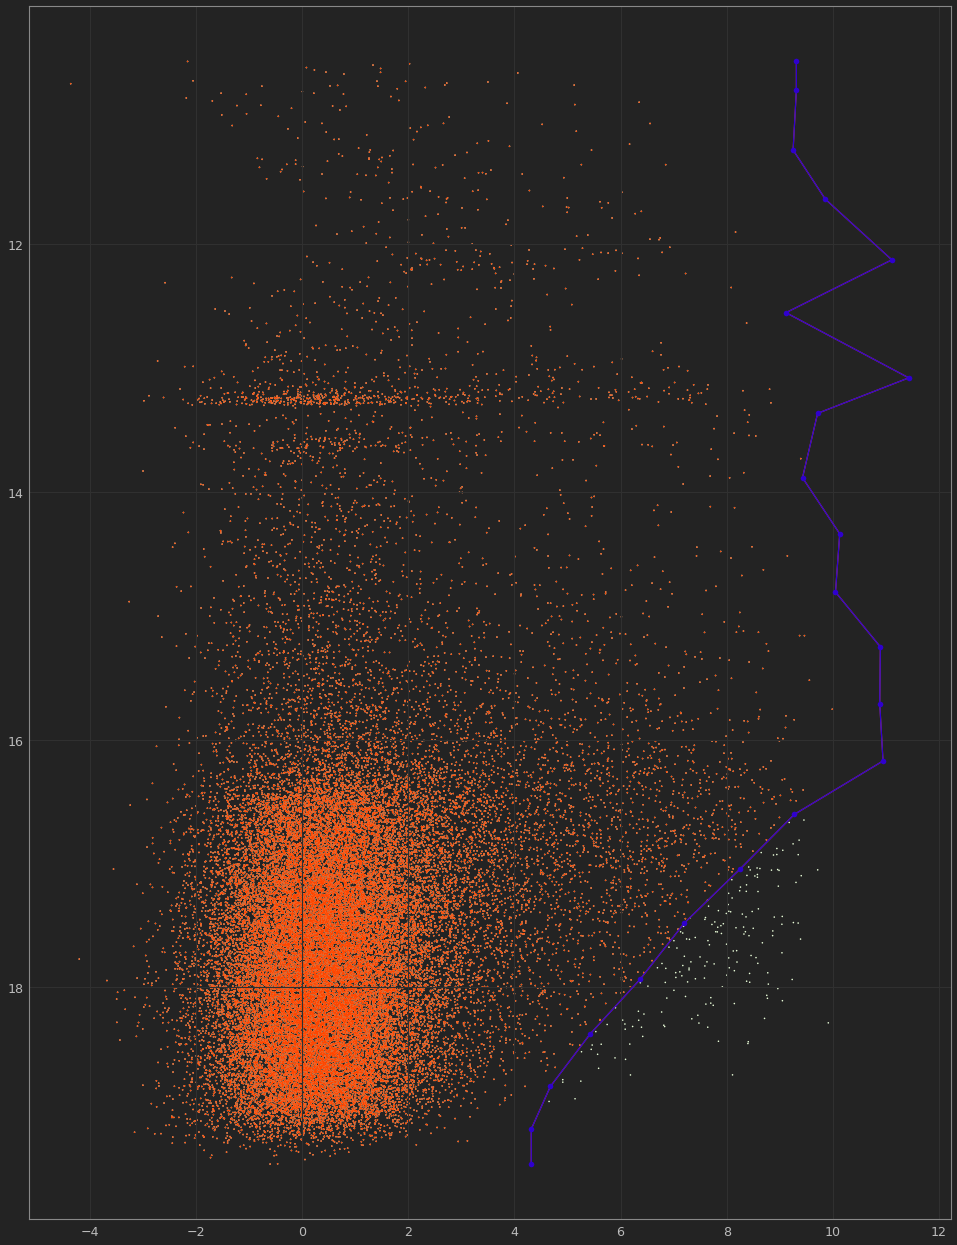

In [130]:
x = []
y = []

gaia_x = testing['astrometric_gof_al']
gaia_y = testing['phot_rp_mean_mag']
data_x = gaia_data['astrometric_gof_al']
data_y = gaia_data['phot_rp_mean_mag']
for j in range(0, len(test.points)):
    y.append(test.points[j].G_RP_mean)
    x.append(test.points[j].median_value + Sigma * test.points[j].std_value)
x_clon = x
y_clon = y
    
plt.plot(x_clon,y_clon, "-r")
plt.plot(x,y, marker='o', color="#2f00ce")
plt.scatter(data_x, data_y, s=2.5, c = "#ebffda", edgecolors='none')
plt.scatter(gaia_x, gaia_y, s=2.5, c = "#ff4600", edgecolors='none')
jtplot.style(theme='monokai') #Jupyter-Notebook Theme
    
plt.rcParams["figure.figsize"] = [13.50, 17.50]
plt.rcParams["figure.autolayout"] = True
plt.gca().invert_yaxis()
plt.show()

In [ ]:
G_RP = gaia_data['pmra']
G_BP = gaia_data['pmdec']
print(G_BP - G_RP)
plt.gca().invert_yaxis()
plt.scatter(G_BP-G_RP , G_BP, s = 0.5)
plt.show()

In [ ]:
hola = [1,2,3,45,5]
hola_np = np.asarray(hola)
mean_val = np.mean(hola_np)
print(mean_val, type(mean_val))

In [ ]:
(18.5 - 11.0)/0.5